In [1]:
from pathlib import Path
import yaml
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results"

In [2]:
from abcnre.simulation.models import GaussGaussModel, GaussGaussMultiDimModel
from abcnre.simulation.samplers import SummarizedStatisticalModel, RejectionSampler
from abcnre.simulation.utils import \
    get_epsilon_quantile, get_io_generator, create_summary_stats_fn, get_discrepancy_fun

from abcnre.training import get_nn_config, train_nn

import jax
import jax.numpy as jnp
from jax import random

from typing import Callable, Tuple, Any, Dict, Optional, Union

import matplotlib.pyplot as plt

key = jax.random.PRNGKey(123)

def comp_plot(x, y, ax=None):
    if ax:
        ax.plot(x, y, 'b.')
        ax.plot(x, x, 'k-')
    else:
        plt.plot(x, y, 'b.')
        plt.plot(x, x, 'k-')

# Set up a model to generate draws from the first component of a 2d Gaussian

In [3]:
model = GaussGaussMultiDimModel(mu0=0., sigma0=1.0, sigma=2.0, dim=2, n_obs=30)
target_ind = 0
model0 = SummarizedStatisticalModel(model, lambda theta: jnp.array([ theta[target_ind] ]))
model_marg = GaussGaussModel(
    mu0=model.mu0[target_ind],
    sigma0=model.sigma0[target_ind, target_ind],
    sigma=model.sigma[target_ind, target_ind],
    n_obs=model.n_obs)

key, _key = jax.random.split(key, 2)
phi_draws, x_draws = model0.sample_theta_x_multiple(_key, 5)
phi_draws

key, _key = jax.random.split(key, 2)
theta_obs, x_obs = model0.sample_theta_x(_key)
post_true = model_marg.get_posterior_stats(x_obs)

# Attempt to learn the optimal summary statistic (the sample mean)

In [5]:
nn_config = get_nn_config(network_name="deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "regressor",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)

In [6]:
print(hasattr(nn_config.training, "stopping_rules"))
print(isinstance(nn_config.training.stopping_rules, dict))
print(hasattr(nn_config.training.stopping_rules, "sample_stopping"))

True
True
False


In [7]:
# RG: Why is it even possible for it to be both StoppingRulesConfig or Dict?
n_samples_max = jnp.inf
if isinstance(nn_config.training.stopping_rules, dict):
    # Working with dictionary format - need to modify it
    if "sample_stopping" not in nn_config.training.stopping_rules:
        nn_config.training.stopping_rules["sample_stopping"] = {}

    nn_config.training.stopping_rules["sample_stopping"]["enabled"] = True
    nn_config.training.stopping_rules["sample_stopping"][
        "max_samples"
    ] = n_samples_max
elif hasattr(nn_config.training.stopping_rules, "sample_stopping"):
    # Working with StoppingRulesConfig object
    nn_config.training.stopping_rules.sample_stopping.enabled = True
    nn_config.training.stopping_rules.sample_stopping.max_samples = (
        n_samples_max
    )

In [8]:
# Train a nn
io_generator = get_io_generator(model0.sample_theta_x_multiple)
key, train_key = random.split(key)
summary_results = train_nn(key=train_key, config=nn_config, io_generator=io_generator)

In [9]:
summary_fn = create_summary_stats_fn(
    network=summary_results.network,
    params=summary_results.params)

## Check the performance against the known optimal summary statistic

In [10]:
key, key_ = random.split(key)
phi_draws, x_draws = model0.sample_theta_x_multiple(key_, n_samples=1000)
x_means = jnp.mean(x_draws[:, :, 0], axis=1) # The correct summary statistic
x_nn_means = summary_fn(x_draws)

Text(0, 0.5, 'NN output')

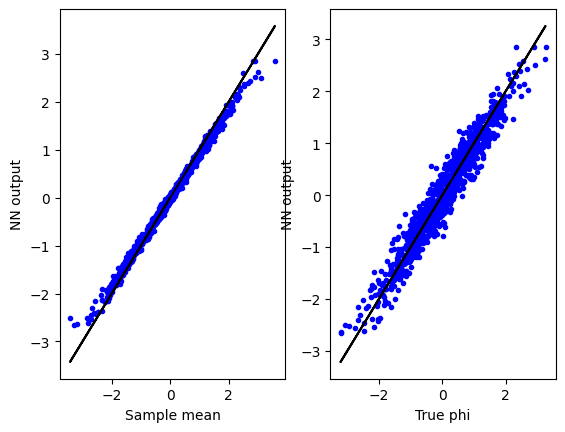

In [11]:
_, axs = plt.subplots(1, 2)
comp_plot(x_means, x_nn_means, axs[0])
axs[0].set_xlabel("Sample mean")
axs[0].set_ylabel("NN output")
comp_plot(phi_draws, x_nn_means, axs[1])
axs[1].set_xlabel("True phi")
axs[1].set_ylabel("NN output")


## Define a rejection sampler using the NN

In [19]:
d_fn = get_discrepancy_fun(x_obs, summary_fn)
key, key_ = random.split(key)
epsilon, epsilons = get_epsilon_quantile(key_, model0.sample_theta_x_multiple, d_fn, alpha=0.1)

print(jnp.mean(epsilons <= epsilon), " = should be appriximately alpha")

0.099999994  = should be appriximately alpha


In [20]:
model_abc = RejectionSampler(model0, discrepancy_fn=d_fn, epsilon=epsilon)

In [21]:
key, key_ = random.split(key)
phi_abc, _ = model_abc.sample_theta_x_multiple(key_, 10000, cache=True)

In [22]:
abc_metadata = model_abc.get_cache(key_, 10000)
print(jnp.mean(abc_metadata.rejection_count))

8.7337


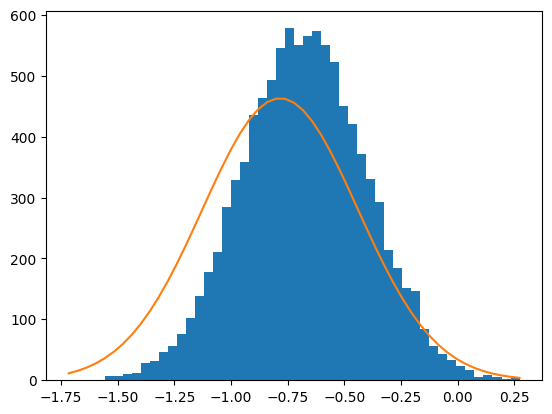

In [23]:
# Compare the true posterior to ABC
post_dist = model_marg.get_posterior_distribution(x_obs)
post_dist.pdf(0.5)

abc_n, abc_bins, _ = plt.hist(phi_abc, 50);
dx = abc_bins[1] - abc_bins[0]
plt.plot(abc_bins, post_dist.pdf(abc_bins) * dx * jnp.sum(abc_n))

# Train a classifier-based NRE

In [18]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")

true_theta = 2.5
key, subkey_sample = jax.random.split(key)
x_obs = simulator.model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs: {x_obs}")

quantile_distance = 1.
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---


NameError: name 'simulator' is not defined

In [ ]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

In [ ]:
print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

key, key_samples, key_samples_load = jax.random.split(key, 3)
samples = simulator_loaded.generate_samples(key_samples, n_samples=100000)
samples_load = simulator_loaded.generate_samples(key_samples_load, n_samples=100000)

import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples.phi.flatten(), label="Samples from simulator"
            )
sns.kdeplot(samples_load.phi.flatten(), label="Samples from loaded simulator")
plt.legend()
plt.title("Phi marginal of the two simulators")
plt.xlabel("Phi samples")

In [ ]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="mlp",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)


nn_config.training.num_epochs = 500
nn_config.training.batch_size = 1024
nn_config.training.n_samples_per_epoch = 10240
nn_config.training.learning_rate = 1e-2
nn_config.training.optimizer= "adamw"
nn_config.training.weight_decay = 1e-3

In [ ]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

In [ ]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")

key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)

In [ ]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


In [ ]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)

key, key_samples_estimator, key_samples_estimator_load = jax.random.split(key, 3)
samples_estimator = estimator.simulator.generate_samples(key_samples_estimator, n_samples=100000)
samples_estimator_load = estimator_loaded.simulator.generate_samples(key_samples_estimator_load, n_samples=100000)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples_estimator.phi.flatten(), label="Samples from estimator")
sns.kdeplot(samples_estimator_load.phi.flatten(), label="Samples from loaded estimator")
plt.legend()
plt.title("Phi marginal of the two estimators") 